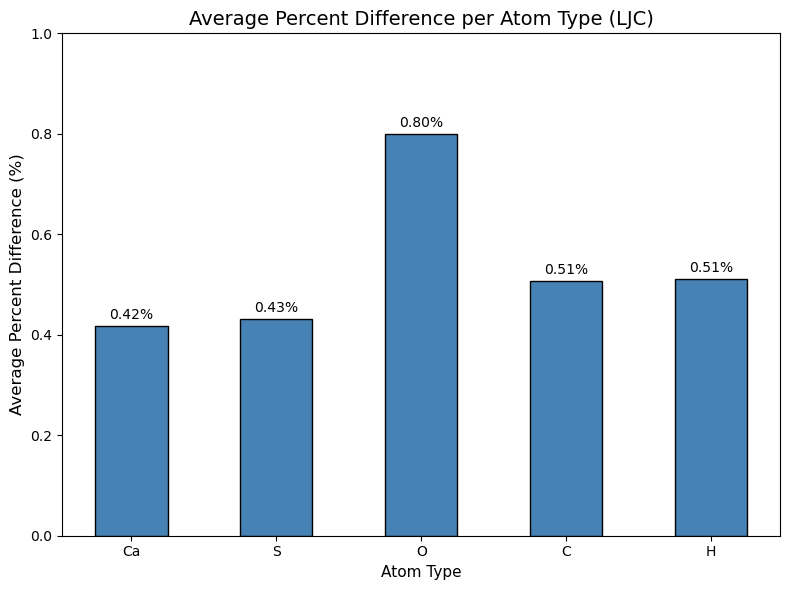

Per-atom percent differences:
Ca      0.335%
Ca      0.668%
Ca      1.011%
Ca      0.407%
S       0.394%
S       0.832%
S       0.632%
S       0.665%
O       0.316%
O       0.562%
O       1.499%
O       0.822%
O       0.376%
O       0.853%
O       0.748%
O       0.645%
O       0.430%
O       0.850%
O       0.781%
O       0.630%
O       0.864%
O       0.440%
O       0.316%
O       1.396%
O       0.366%
O       0.362%
O       1.297%
O       0.927%
O       0.731%
O       0.315%
O       0.225%
O       1.065%
C       0.736%
C       0.400%
C       0.261%
C       1.126%
C       0.345%
C       0.345%
C       1.230%
C       0.818%
C       0.441%
C       0.636%
C       2.140%
C       0.876%
H       0.513%
H       0.688%
H       2.405%
H       1.067%
C       0.480%
C       0.745%
C       0.435%
C       0.849%
H       0.453%
H       0.772%
H       0.467%
H       0.861%
C       0.524%
C       0.708%
C       0.542%
C       0.827%
H       0.516%
H       0.773%
H       0.685%
H       0.827%
C       0.

In [ ]:
# code to calculate the per-atom error in average coordinates over MD trajectory
# last modified nov. 24, 2025

import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# define the functions we will use
def read_xyz(filepath):
    """returns list of (atom type, np.array([x,y,z]))"""
    atoms = []
    with open(filepath) as f:
        lines = f.readlines()[2:]  # skip atom count + comment line
        for line in lines:
            parts = line.split()
            atom = parts[0]
            xyz = np.array(list(map(float, parts[1:4])))
            atoms.append((atom, xyz))
    return atoms

def percent_differences(avg298, avg150):
    """computes percent difference in coordinates per atom"""
    results = []
    for (atomA, coordA), (atomB, coordB) in zip(avg298, avg150):
        # in case atom type doesn't match...
        assert atomA == atomB, "Atom mismatch at some line."

        diff = np.linalg.norm(coordA - coordB)
        magA = np.linalg.norm(coordA)
        percent = (diff / magA) * 100 if magA != 0 else 0.0

        results.append((atomA, percent))
    return results

def average_by_atom_type(results):
    """average percent difference per atom type"""
    groups = defaultdict(list)
    for atom, pct in results:
        groups[atom].append(pct)

    return {atom: np.mean(vals) for atom, vals in groups.items()}

# CO2 geometry functions
def distance(a, b):
    return np.linalg.norm(a - b)

def angle(a, b, c):
    """ dihedral angle ABC in degrees (B is vertex)"""
    BA = a - b
    BC = c - b
    cosang = np.dot(BA, BC) / (np.linalg.norm(BA) * np.linalg.norm(BC))
    return np.degrees(np.arccos(np.clip(cosang, -1.0, 1.0)))

def analyze_co2(avg298, avg150):
    """ analyze position and geometry change of last 3 atoms (CO2)."""
    co2A = avg298[-3:]  # (atom type, coord)
    co2B = avg150[-3:]

    # unpack coordinates only
    atomsA, coordsA = zip(*co2A)
    atomsB, coordsB = zip(*co2B)
    coordsA = list(coordsA)
    coordsB = list(coordsB)

    # per-atom displacements
    displacements = [distance(a, b) for a, b in zip(coordsA, coordsB)]

    # COM displacement (mass O=16, C=12)
    masses = {"C": 12.0, "O": 16.0}
    mA = sum(masses[a] for a in atomsA)
    comA = sum(masses[a] * coord for a, coord in co2A) / mA
    comB = sum(masses[a] * coord for a, coord in co2B) / mA
    com_disp = distance(comA, comB)

    # identify C atom index
    idxC = atomsA.index("C")
    idxO1, idxO2 = [i for i in range(3) if i != idxC]

    # bond lengths
    bondA1 = distance(coordsA[idxC], coordsA[idxO1]) # O1=C
    bondA2 = distance(coordsA[idxC], coordsA[idxO2]) # C=O2
    bondB1 = distance(coordsB[idxC], coordsB[idxO1]) # O1=C
    bondB2 = distance(coordsB[idxC], coordsB[idxO2]) # C=O2

    # bond angle
    angA = angle(coordsA[idxO1], coordsA[idxC], coordsA[idxO2]) # O-C-O dihedral
    angB = angle(coordsB[idxO1], coordsB[idxC], coordsB[idxO2]) # O-C-O dihedral

    return {
        "atom_labels": atomsA,
        "per_atom_displacements": displacements,
        "COM_displacement": com_disp,
        "bond_lengths_A": (bondA1, bondA2),
        "bond_lengths_B": (bondB1, bondB2),
        "bond_length_changes": (bondB1 - bondA1, bondB2 - bondA2),
        "angle_A": angA,
        "angle_B": angB,
        "angle_change": angB - angA,
    }

# histogram plotting
def plot_average_percent_difference(per_type):
    atom_types = list(per_type.keys())
    values = [per_type[a] for a in atom_types]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(atom_types, values, width=0.5, color='steelblue', edgecolor='black')

    # add value labels above bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2,
                 yval + 0.01 * max(values),
                 f"{yval:.2f}%",
                 ha='center', va='bottom', fontsize=10)

    plt.ylabel("Average Percent Difference (%)", fontsize=12)
    plt.xlabel("Atom Type", fontsize=11)
    plt.ylim((0,1))
    plt.title("Average Percent Difference per Atom Type (LJC)", fontsize=14)
    plt.tight_layout()
    plt.show()

###### time to calculate ######

# read in file from each run
avg298 = read_xyz(f"/Users/lclemens/Downloads/Homework Scripts/ME508/298K_avg_structure_ljc.xyz")
avg150 = read_xyz(f"/Users/lclemens/Downloads/Homework Scripts/ME508/150K_avg_structure_ljc.xyz")

# compute functions
per_atom = percent_differences(avg298, avg150)
per_type = average_by_atom_type(per_atom)
co2_results = analyze_co2(avg298, avg150)

#plot
plot_average_percent_difference(per_type)

# some printable info
print("Per-atom percent differences:")
for atom, pct in per_atom:
    print(f"{atom:3s}  {pct:8.3f}%")

print("\nAverage percent difference per atom type:")
for atom, avg in per_type.items():
    print(f"{atom:3s}  {avg:8.3f}%")

print("\n=== CO2 Geometry ===")
print("Atom order:", co2_results["atom_labels"])
print("Per-atom displacements (Å):", co2_results["per_atom_displacements"])
print("Center-of-mass displacement (Å):", co2_results["COM_displacement"])
print("Bond lengths A (Å):", co2_results["bond_lengths_A"])
print("Bond lengths B (Å):", co2_results["bond_lengths_B"])
print("Bond length changes (Å):", co2_results["bond_length_changes"])
print("Angle A (deg):", co2_results["angle_A"])
print("Angle B (deg):", co2_results["angle_B"])
print("Angle change (deg):", co2_results["angle_change"])